# Deep Learning Tensorflow/Keras approach 
    -> Ressources: 
    https://towardsdatascience.com/building-a-multi-output-convolutional-neural-network-with-keras-ed24c7bc1178
    https://keras.io/guides/functional_api/
    (Multi-Output-Network)

In [14]:
import pandas as pd

df = pd.read_csv("../static_merged_data.csv")
df.head()


,T_min,T_max,T_delta,Pow_mean,status
0,24.559295,27.063301,2.504006,0.0,drossel
1,24.559295,27.063301,2.504006,0.0,drossel
2,24.559295,27.063301,2.504006,0.0,drossel
3,24.559295,27.063301,2.504006,0.0,drossel
4,24.559295,27.063301,2.504006,0.0,drossel


In [121]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# devide it into labels and features
Y = df[["status"]]
X = df[["T_min","T_max","T_delta","Pow_mean"]]

# split the dataset into train- and testset
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=.2)

#y_categ = to_categorical(Y,3) #does not work: only integers
y_train.head()

,status
18602,drossel
53579,mosfets
6195,drossel
74907,normal
85585,normal


In [103]:
from keras.utils import to_categorical
pd_series_nums = y_train.status.astype('category').cat.codes.to_numpy()
labels = to_categorical(pd_series_nums, 3)
labels.shape

(77079, 3)

In [104]:
X_numpy = X_train.to_numpy()
#X_numpy.resize(96349,1,4)
X_numpy.shape

(77079, 4)

In [122]:
def prepare_train_test_set(X, Y, num_classes):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=.2)
    train_labels = y_train.status.astype('category').cat.codes.to_numpy()
    test_labels = y_test.status.astype('category').cat.codes.to_numpy()
    train_labels = to_categorical(train_labels, num_classes)
    test_labels = to_categorical(test_labels, num_classes)
    X_train.to_numpy()
    X_test.to_numpy()
    return (X_train, X_test), (train_labels, test_labels)

In [123]:
(X_train, X_test), (train_labels, test_labels) = prepare_train_test_set(X,Y,3)

In [6]:
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
import tensorflow as tf
from  keras import Sequential

model = Sequential([
    Input(shape=(4,), name="input-layer"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(16, activation="relu"),
    Dense(3, activation="softmax", name="output_layer")
], name="DCDC_type_classifier")

model.summary()

Model: "DCDC_type_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                320       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 output_layer (Dense)        (None, 3)                 51        
                                                                 
Total params: 9,731
Trainable params: 9,731
Non-trainable params: 0
_________________________________________________________________


In [135]:
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=["acc"])

history = model.fit(X_train, train_labels, 256, 50, validation_split=0.1)

Epoch 1/50
271/271 [==============================] - 2s 3ms/step - loss: 1.0154 - acc: 0.4699 - val_loss: 0.9414 - val_acc: 0.5448
Epoch 2/50
271/271 [==============================] - 1s 2ms/step - loss: 0.8687 - acc: 0.6073 - val_loss: 0.7885 - val_acc: 0.7156
Epoch 3/50
271/271 [==============================] - 1s 2ms/step - loss: 0.7043 - acc: 0.7181 - val_loss: 0.5962 - val_acc: 0.7966
Epoch 4/50
271/271 [==============================] - 1s 2ms/step - loss: 0.5554 - acc: 0.7933 - val_loss: 0.4579 - val_acc: 0.8661
Epoch 5/50
271/271 [==============================] - 1s 2ms/step - loss: 0.4352 - acc: 0.8465 - val_loss: 0.6018 - val_acc: 0.6925
Epoch 6/50
271/271 [==============================] - 1s 2ms/step - loss: 0.3786 - acc: 0.8560 - val_loss: 0.3702 - val_acc: 0.8365
Epoch 7/50
271/271 [==============================] - 1s 2ms/step - loss: 0.3068 - acc: 0.8850 - val_loss: 0.4973 - val_acc: 0.7305
Epoch 8/50
271/271 [==============================] - 1s 2ms/step - loss: 0.

In [136]:
import matplotlib.pyplot as plt


# function for plotting the history including validation/training loss and accuracy
def plot_history(history, epochs_size):
    loss = history.history["loss"]
    accuracy = history.history["acc"]
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_acc"]
    # max_acc = accuracy[np.argmax(accuracy)]
    # max_val_acc = val_accuracy[np.argmax(val_accuracy)]
    epochs = range(1, (epochs_size+1))
    ig, ax = plt.subplots(2, figsize=(20, 8))
    ax[0].plot(epochs ,loss, "b", label="Training loss")
    ax[0].plot(epochs, val_loss, "r", label="Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()
    ax[1].plot(epochs, accuracy, "g", label="Training accuracy")
    ax[1].plot(epochs, val_accuracy, "y", label="Validation accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()
    

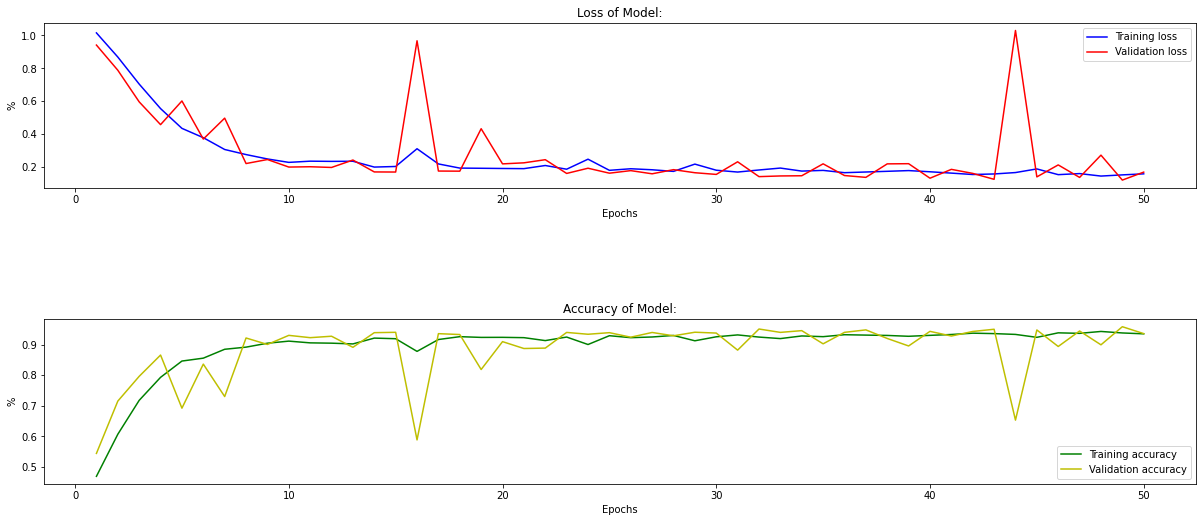

In [137]:
plot_history(history=history, epochs_size=50)

In [2]:
dataset_dict = {
    'song': {
        0: 'neelix', 
        1: 'ng', 
        2: 'pieces'
    },

    'dcdc': {
        0: 'mosfets',
        1: 'normal',
        2: 'drossel'
    }
}
dataset_dict['song_alias'] = dict((g, i) for i, g in dataset_dict['song'].items())
dataset_dict['dcdc_alias'] = dict((r, i) for i, r in dataset_dict['dcdc'].items())
print(dataset_dict)

IM_WIDTH = 321 
IM_HEIGHT = 123

{'song': {0: 'neelix', 1: 'ng', 2: 'pieces'}, 'dcdc': {0: 'mosfets', 1: 'normal', 2: 'drossel'}, 'song_alias': {'neelix': 0, 'ng': 1, 'pieces': 2}, 'dcdc_alias': {'mosfets': 0, 'normal': 1, 'drossel': 2}}


In [3]:
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf
class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x
    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)
        return x
    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)
        return x
    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)
        return x
    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)
        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")
        return model
    
# model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=4)


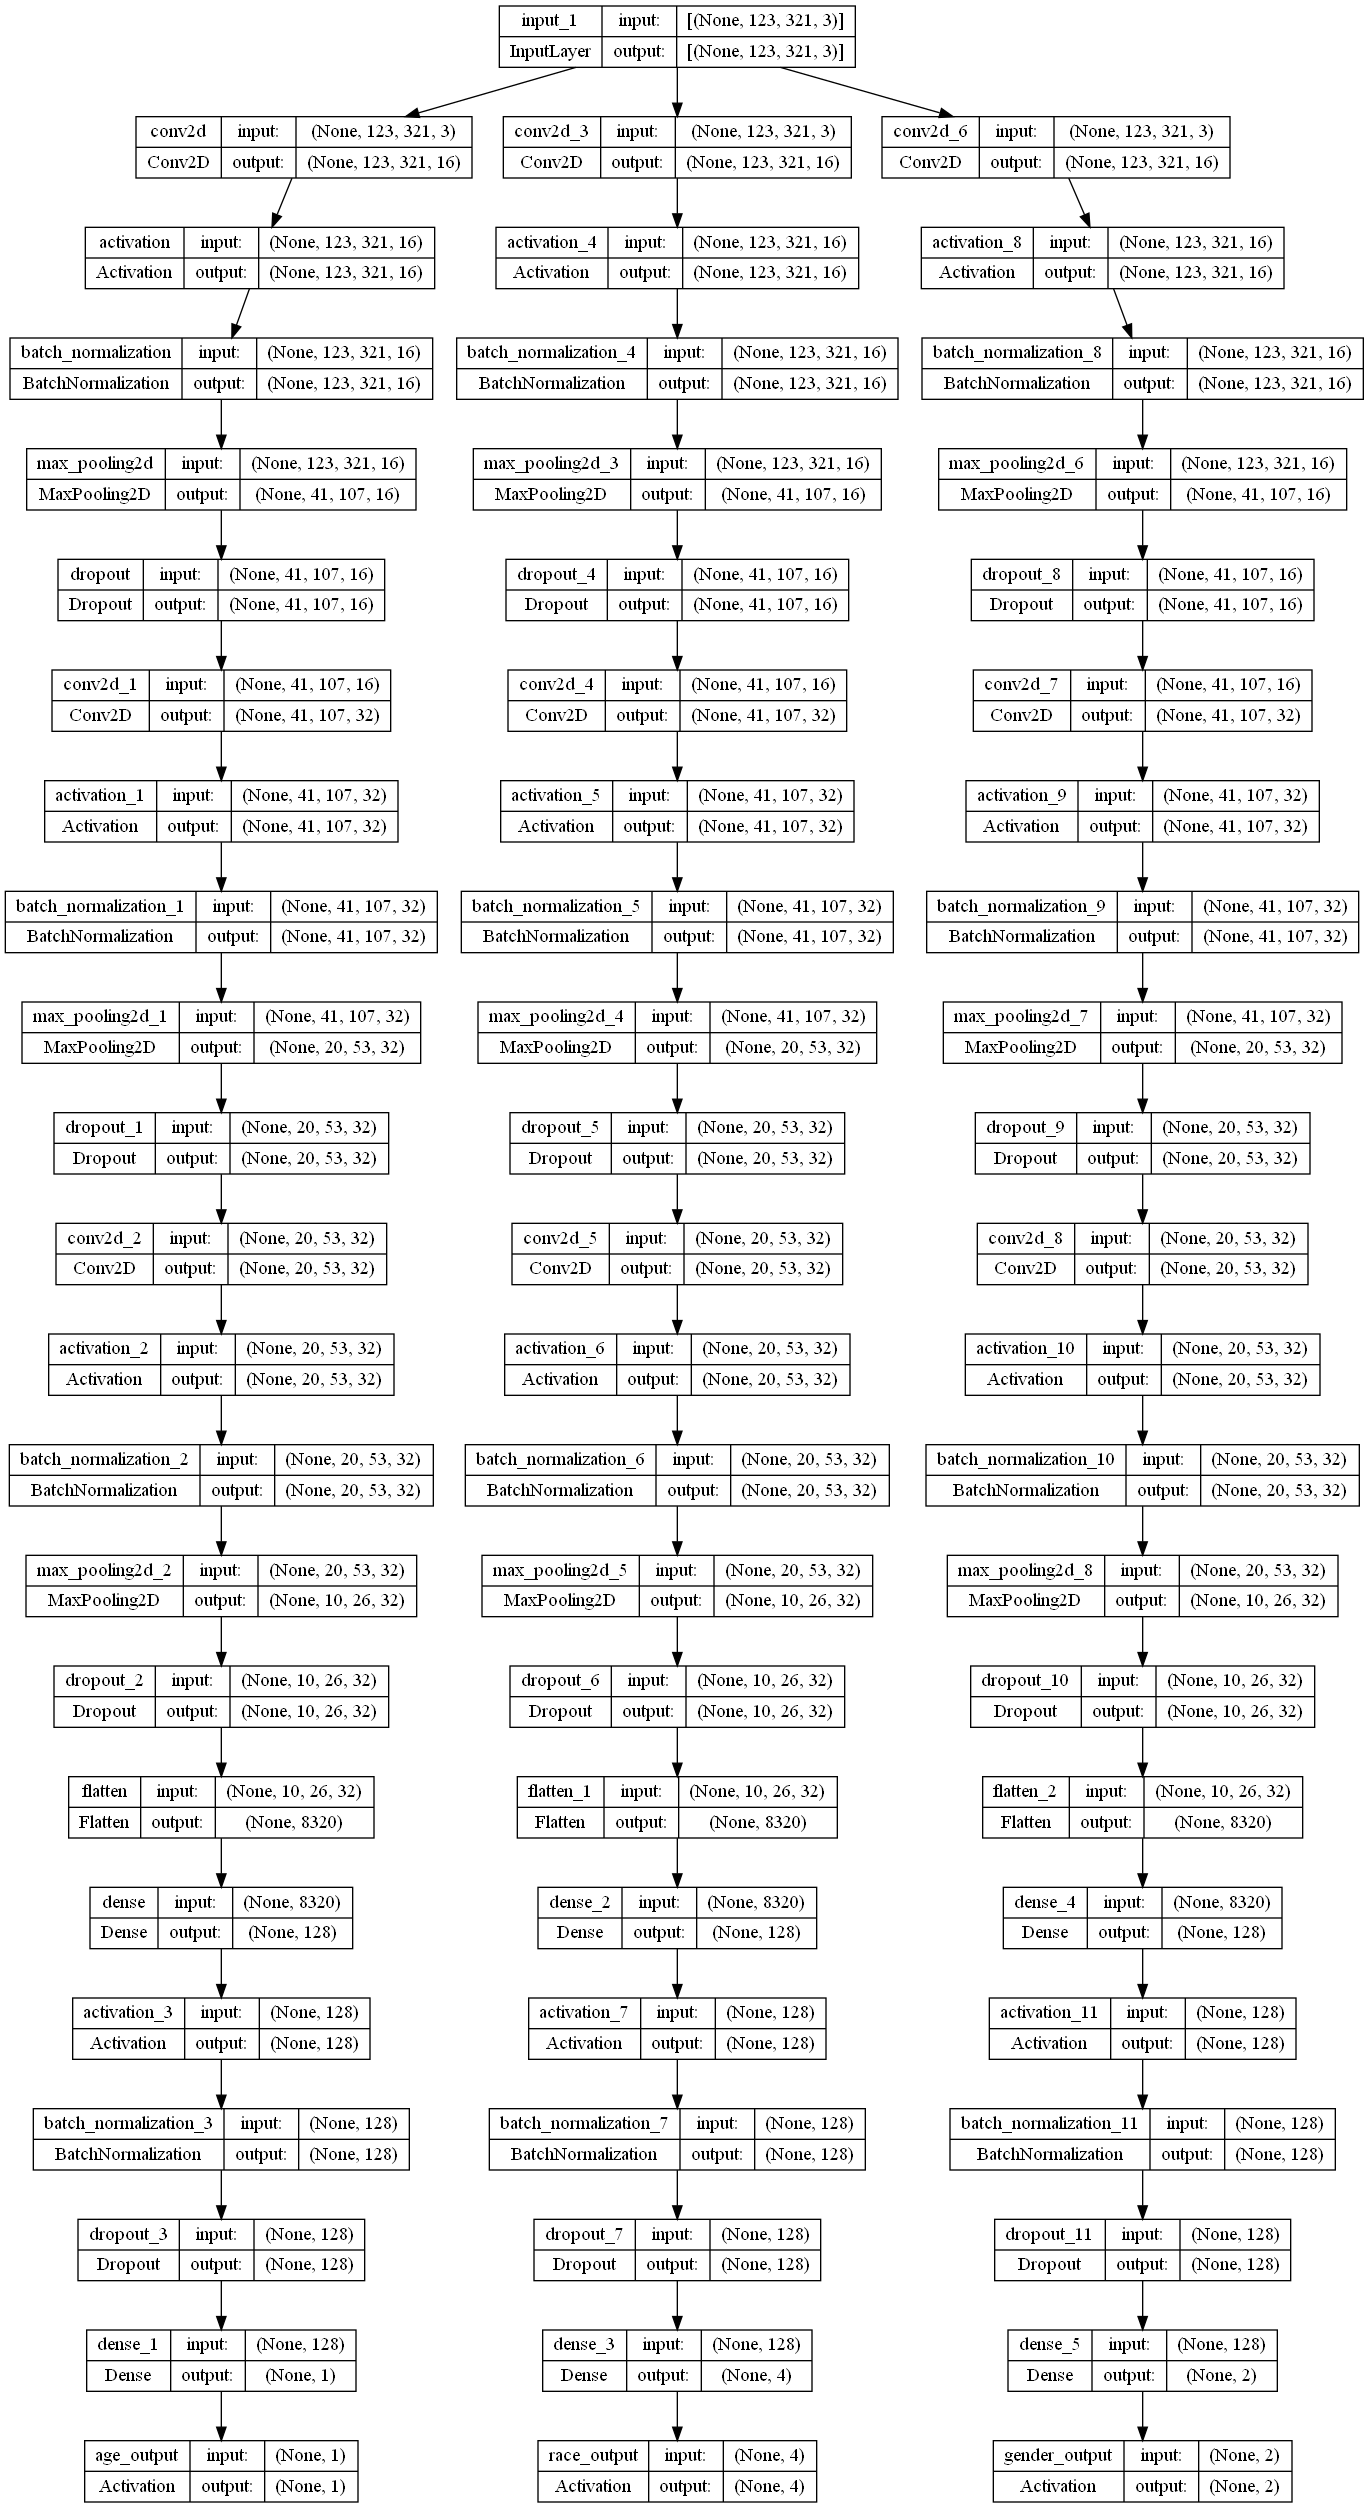

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(model, "model_1.png", show_shapes=True)